In [2]:
import os
import zipfile
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import torch.nn.functional as F
from google.colab import drive
import zipfile

Mounted at /content/drive
+------------+--------------+------------------------+
| Data Split | Total Images |      Image Shape       |
+------------+--------------+------------------------+
|  Training  |     9664     | torch.Size([128, 128]) |
|  Testing   |     544      | torch.Size([128, 128]) |
| Validation |     1120     | torch.Size([128, 128]) |
+------------+--------------+------------------------+


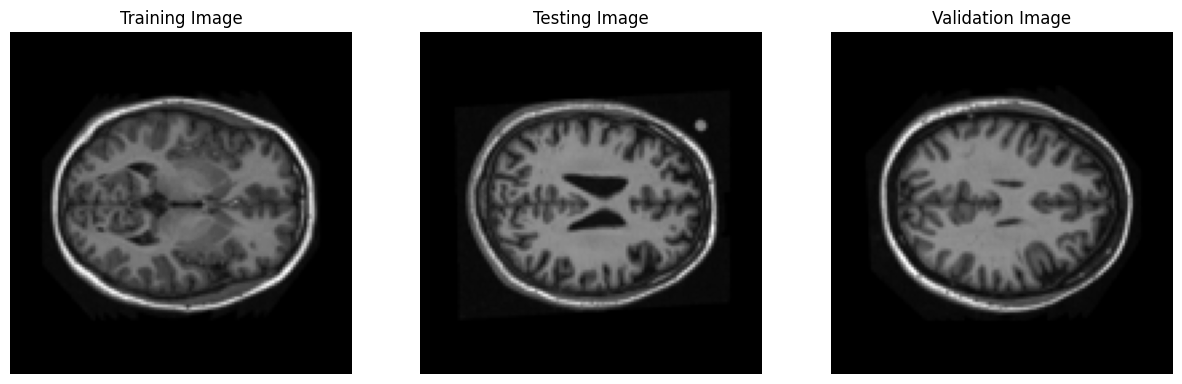

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

In [3]:
# Ensure that PyTorch uses the GPU (if available) or CPU otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mounting Google Drive to access files. Note: This is specific to Google Colab.
drive.mount('/content/drive')

# Define the directory where the output will be saved
OUTPUT_DIR = "/content/drive/MyDrive/Colab_Notebooks_Course/image_process/A3/OUTPUT2"

# Create the directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Dataset class to handle brain slice images
class BrainSlicesDataset(Dataset):
    def __init__(self, image_slices):
        self.image_slices = image_slices

    def __len__(self):
        # Return the total number of image slices
        return len(self.image_slices)

    def __getitem__(self, idx):
        image = self.image_slices[idx]

        # Ensure the image has a channel dimension (grayscale images may not have one)
        if len(image.shape) == 2:  # If the image is of shape [Height, Width]
            image = torch.unsqueeze(image, 0)  # Convert it to [1, Height, Width]

        return image


# Function to load and extract image slices from a zip file
def get_image_slices():
    # Path to the zipped dataset
    zip_path = "/content/drive/MyDrive/Colab_Notebooks_Course/image_process/A3/testgans/GAN_Dataset.zip"
    extraction_path = "/content/GAN_Dataset"
    # Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)

    # Define the directories for training, testing, and validation datasets
    parent_dir = "/content/GAN_Dataset"
    train_path = os.path.join(parent_dir, "keras_png_slices_train")
    test_path = os.path.join(parent_dir, "keras_png_slices_test")
    val_path = os.path.join(parent_dir, "keras_png_slices_validate")

    # Helper function to load images from a directory
    def load_images_from_folder(folder_path):
        images = []
        for filename in os.listdir(folder_path):
            # Open the image, convert to grayscale, and resize to 128x128 pixels
            img = Image.open(os.path.join(folder_path, filename)).convert('L').resize((128, 128))
            if img is not None:
                # Convert the image to a tensor and append to the list
                images.append(torch.tensor(np.array(img, dtype=np.float32)))
        return torch.stack(images)  # Convert list of tensors to a single tensor

    # Load images from each directory
    train_images = load_images_from_folder(train_path)
    test_images = load_images_from_folder(test_path)
    validate_images = load_images_from_folder(val_path)

    return train_images, test_images, validate_images


# Function to retrieve the image slices and provide a summary with a table and example images
def get_image_slices_with_table():
    train_images, test_images, validate_images = get_image_slices()

    # Display a summary table using PrettyTable
    table = PrettyTable()
    table.field_names = ["Data Split", "Total Images", "Image Shape"]
    table.add_row(["Training", len(train_images), train_images[0].shape])
    table.add_row(["Testing", len(test_images), test_images[0].shape])
    table.add_row(["Validation", len(validate_images), validate_images[0].shape])

    print(table)

    # Plot an example image from each dataset split
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(train_images[0], cmap='gray')
    axs[0].set_title("Training Image")
    axs[0].axis('off')

    axs[1].imshow(test_images[0], cmap='gray')
    axs[1].set_title("Testing Image")
    axs[1].axis('off')

    axs[2].imshow(validate_images[0], cmap='gray')
    axs[2].set_title("Validation Image")
    axs[2].axis('off')

    plt.show()

    return train_images, test_images, validate_images

# Call the function to display the dataset summary and example images
get_image_slices_with_table()

In [4]:
# 2. Model Definitions

# --- VectorQuantizer Layer ---
# This layer is responsible for quantizing the continuous embeddings produced by the encoder into discrete codes.
# It is the core component of the VQ-VAE which allows for a discrete latent representation.
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        # `num_embeddings`: Number of embeddings (or clusters)
        # `embedding_dim`: Dimensionality of each embedding
        # `beta`: Weight for the commitment loss term
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta
        # Initialize the embeddings (cluster centers)
        self.embeddings = nn.Parameter(torch.randn(embedding_dim, num_embeddings))

    def forward(self, x):
        # Reshape input tensor and calculate distances between input and embeddings
        z_e_x = x.permute(0, 2, 3, 1).contiguous()
        z_e_x_ = z_e_x.view(-1, self.embedding_dim)
        distances = (torch.sum(z_e_x_**2, dim=1, keepdim=True)
                    + torch.sum(self.embeddings**2, dim=0)
                    - 2 * torch.matmul(z_e_x_, self.embeddings))
        # Get the closest embedding index for each element in the batch
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings).to(x.device)
        encodings.scatter_(1, encoding_indices, 1)
        encoding_indices = encoding_indices.view(*z_e_x.shape[:-1])
        # Quantize the input tensor (replace input tensor values with their closest embeddings)
        quantized = torch.matmul(encodings, self.embeddings.t()).view(*z_e_x.shape)
        # Calculate the VQ-VAE loss
        e_latent_loss = F.mse_loss(quantized.detach(), z_e_x)
        q_latent_loss = F.mse_loss(quantized, z_e_x.detach())
        loss = q_latent_loss + self.beta * e_latent_loss
        # Add the straight-through estimator (for backpropagation)
        quantized = z_e_x + (quantized - z_e_x).detach()
        # Calculate the perplexity - a measure of how many embeddings are being used
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices
